In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
from pathlib import Path
import joblib

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

In [2]:
from src.Bayesian import *
from src.Bayesian.problems.config import config_fgt
from src.Bayesian.problems import *
from src.Bayesian.utils.optimizer import Optimizer, ConstantDict
from src.Bayesian.utils.model_evaluation import ModelEval

In [3]:
# Example module config
module_config = {
    "perception": (BasePerception, {}),
    "memory": (BaseMemory, {
        "personal_memory_range": {
            "gamma": (0.05, 1.0),
            "w0": (0.075, 0.15)
        },
        "param_resolution": 20
    }),
    "cluster": (PartitionCluster, {
        "transition_spec": [("random_4", "top_posterior"),
                            ("opp_random_4", "random")],
        "init_strategy": [(3, "random")]
    }),
}
optimizer = Optimizer(module_config, n_jobs=100)

# 导入数据
processed_path = Path(project_root) / 'data' / 'processed'
optimizer.prepare_data(processed_path / 'Task2_processed.csv')

In [4]:
iSub = 13
training_results = optimizer.optimize_params_with_subs_parallel(
    config_fgt, [iSub], 16, 5, 1000, stop_at=0.8)

Computing error for params: 100%|██████████| 1000/1000 [00:39<00:00, 25.33it/s]


In [8]:
iSub = 13
test_results = optimizer.on_policy_with_subs_parallel(training_results,
    config_fgt, [iSub], 16, 10)

Computing error for params: 100%|██████████| 10/10 [00:00<00:00, 6079.58it/s]
Process LokyProcess-392:
Traceback (most recent call last):
  File "/home/yangjiong/.conda/envs/bayes/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/yangjiong/.conda/envs/bayes/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/yangjiong/.conda/envs/bayes/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py", line 478, in _process_worker
    _process_reference_size = _get_memory_usage(pid, force_gc=True)
  File "/home/yangjiong/.conda/envs/bayes/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py", line 109, in _get_memory_usage
    gc.collect()
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
full_trajectory = training_results[iSub]["best_step_results"] + test_results[iSub]["best_step_results"]

In [ ]:
# save results
result_path = Path(project_root) / 'results' / 'Model_results'
os.makedirs(result_path, exist_ok=True)

optimizer.save_results(results, 'M7_PMH_sub1', result_path)

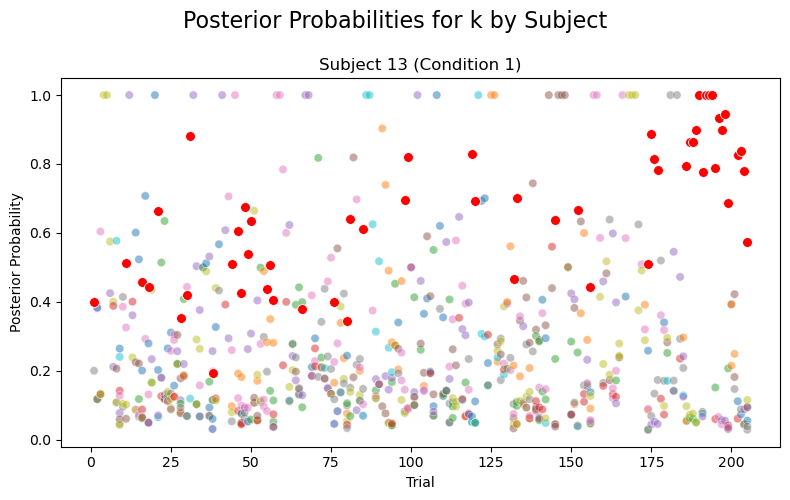

In [57]:
model_eval = ModelEval()
model_eval.plot_posterior_probabilities(training_results, [iSub])

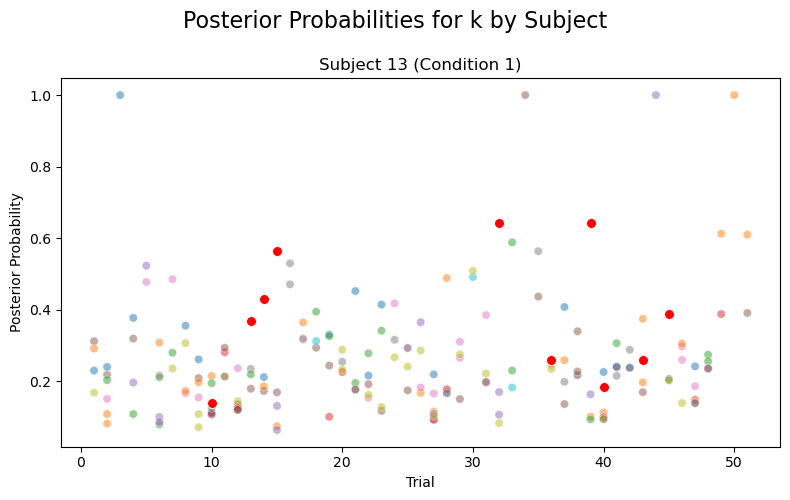

In [55]:
model_eval.plot_posterior_probabilities(test_results, [iSub])

In [ ]:
optimizer.set_results(training_results)
prediction = optimizer.predict_with_subs_parallel(
    config_fgt, [iSub])

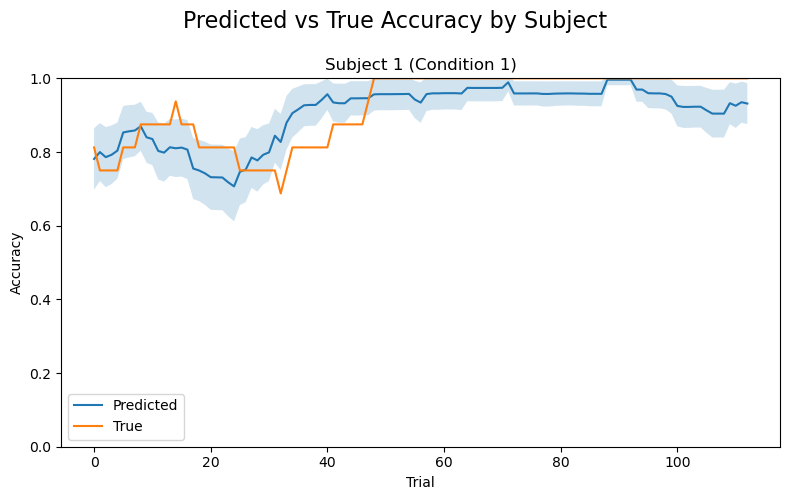

In [7]:
model_eval.plot_accuracy_comparison(prediction, [iSub])

In [8]:
from src.Bayesian.utils.oral_process import Oral_to_coordinate
oral_to_coordinate = Oral_to_coordinate()

learning_data = pd.read_csv(processed_path / 'Task2_processed.csv')
oral_hypo_hits = oral_to_coordinate.get_oral_hypo_hits(learning_data)

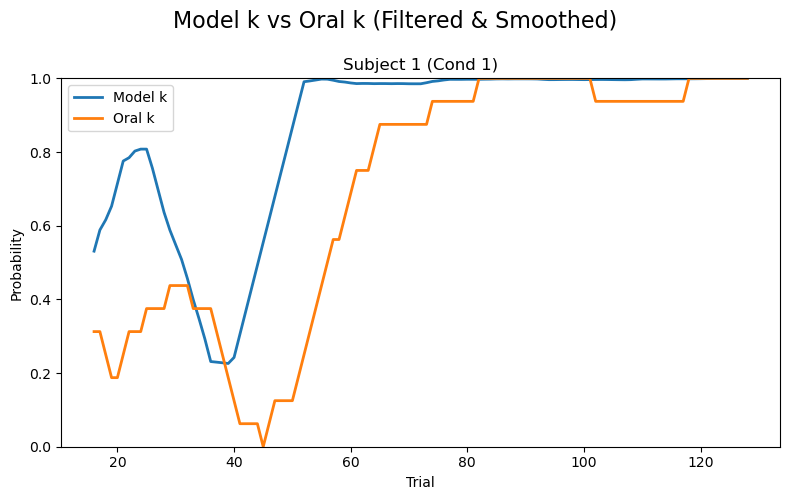

In [9]:
model_eval.plot_k_oral_comparison(results, oral_hypo_hits, [iSub])

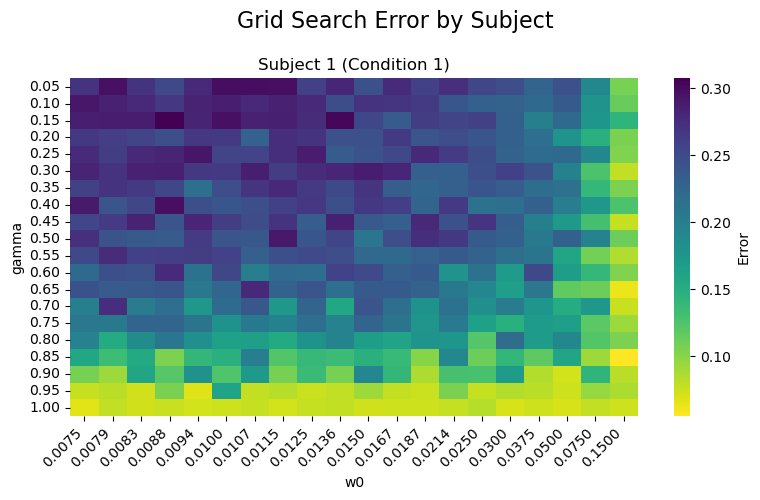

In [12]:
model_eval.plot_error_grids(results, fname=['gamma','w0'])

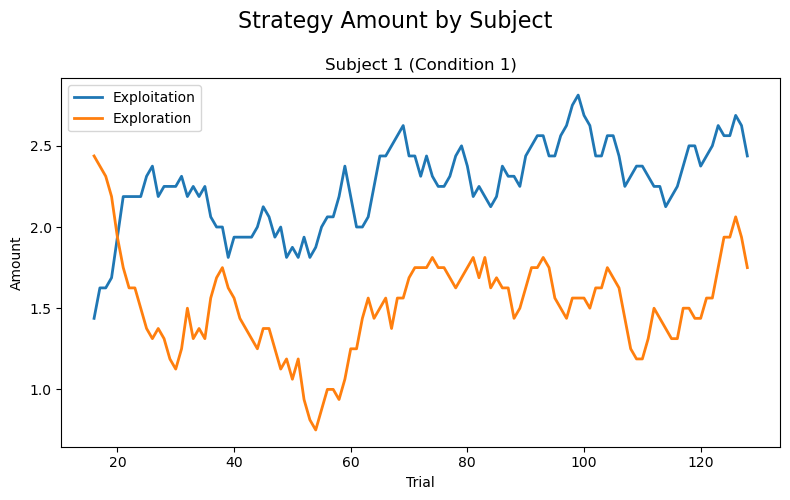

In [13]:
model_eval.plot_cluster_amount(results, 16, [iSub])